In [ ]:
#difeq matlab recreation

In [50]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [60]:
from getpass import getpass
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [75]:
import json

In [ ]:
token = os.getenv('GITHUB_TOKEN')

repo_name = 'Emberflurry/Boillet_DT_Sim_v1'
file_name = 'boilletmain_setup1.ipynb'
commit_message = 'Automatic backup from Colab'

# Backup Path in Google Drive
backup_path = '/content/drive/MyDrive/MDSCFP25/' + file_name

# Verify the file exists before proceeding
if os.path.exists(backup_path):
    print(f"Found {backup_path}, proceeding with backup.")
else:
    raise FileNotFoundError(f"File not found: {backup_path}")

# Configure Git
!git config --global user.email "juandelbosque373@gmail.com"
!git config --global user.name "Emberflurry"

# Remove existing repo folder if it exists
if os.path.exists('Boillet_DT_Sim_v1'):
    !rm -rf Boillet_DT_Sim_v1

# Clone the repository
!git clone https://{os.environ['GITHUB_TOKEN']}@github.com/{repo_name}.git

# Change to repo directory
%cd Boillet_DT_Sim_v1

# Copy the notebook to the repo
!cp {backup_path} .
with open(backup_path, 'r') as f:
    notebook_data = json.load(f)

for cell in notebook_data.get('cells', []):
    if cell.get('cell_type') == 'code':

# Save the sanitized notebook
sanitized_path = backup_path.replace('.ipynb', '_sanitized.ipynb')
with open(sanitized_path, 'w') as f:
    json.dump(notebook_data, f, indent=1)

print(f"Sanitized notebook saved to: {sanitized_path}")
# Add, commit, and push the file to GitHub
!cp {sanitized_path} .

# Add, commit, and push the sanitized notebook
!git add {os.path.basename(sanitized_path)}
!git commit -m "{commit_message}"
!git push origin main

In [ ]:
#from boilletmain:
#(f) = fixed for an athlete
#(d) = dynamic for an athlete
# phi = height of O above bottom of System

# D flow rate
#indic indicator function: 1 if true, 0 else
# V volume, Vdot wrt time
# (f) theta

In [ ]:
#test params:
#from Cyclist 1:
phi = .3  #from [27]+e2.5, or use .25 by [17]
theta = .43
lamb = .38
M_O=1.34 # max energy flux via aerobic. = VO2max * C1 (efficiency term)
M_P = 4.48  # max energy flux w/o any prior fatigue. = Pmech_max / n (efficiency)
M_G = 9.15
M_R = 3.66
A_P = 27.79  # ~ max energy that could b extracted from ATP+PC in the working muscle. assumed ATP const. = amt of PC stores assuming full depletion of em possible. = [PC]muscle(max) * massMuscle * C3 w C3=43.3J/mmol[7] and [PC]=20mmol/kg wet weight typically [27,35]
A_G = 320.3
A_T = 11.27  # indir rep muscular lactate conc at LT1. = [La]muscle@LT1 / theta * massMuscle * C2 (i think all over)
#C2 = 100J/mmol [7]


720 total seconds of test
Pmec failure at t= 496 s
Ptank failure at t= 624 s


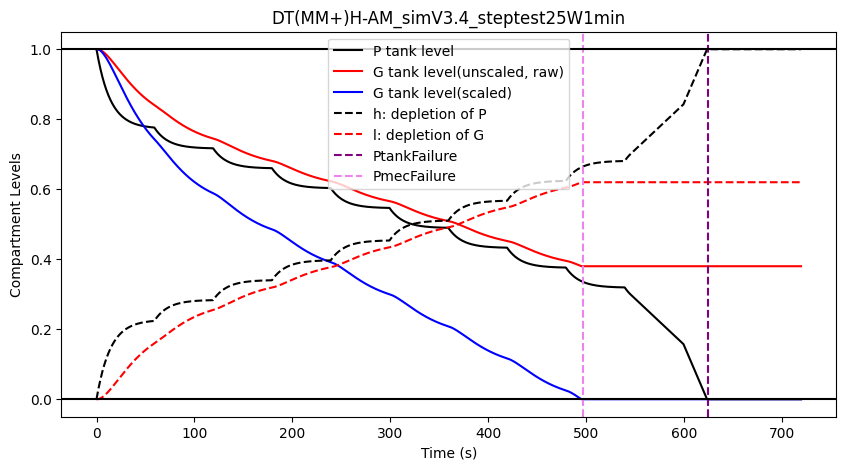

pmec W 247.3 fr pwrfrac, for constPwr sims only (ignore otherwise)
Pphys W 1075.2 fr pwrfrac, for constPwr sims only (ignore otherwise)
W from O2@end 308.2 W. i think correct
@end Pmax theo.: 0.0 W
VO2max of athlete: 64.1 ml/kg/min, at weight in kg of 64kg?? (need calc)
Max effective Pmec from aerobic 308.2 W (potential/limit)
WRONG FIX Crit Power % of VO2max (aerobic component only): 83.1 % see note below
from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max)
@end h, l, theta
1.0 0.62 0.43
Pmec@fail: 350 W


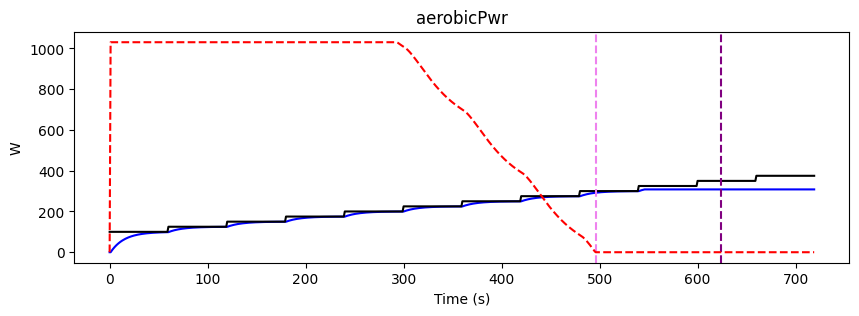

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define model parameters (example values, these should be individualized)
param_c1 = { # for Cyclist 1
    'eta': 0.23,  # Efficiency factor = Pmec@LT1/(%VO2max@LT1 * VO2max * C1)
    'MO': 1.34,   # Max oxidative energy flux (kJ/s)
    'MP': 4.48,   # Max mechanical power (kJ/s) = Pmec(max) / eta
    'MG': 9.15,   # Max glycolytic flux (kJ/s). MG of 285J/kg(muscle mass involved in task)
    'MR': 3.66,   # Max lactate recovery rate (kJ/s) = MG/2.5
    'AP': 27.79,  # Phosphagen store (kJ)
    'AG': 320.3,  # Glycolytic store (kJ)
    'AT': 11.27,  # Capillary glycolytic store (kJ) = [La]muscle@LT1 / theta * massMuscle * C2 (i think all over)
    'phi': 0.30,  # Height of O relative to P
    'theta': 0.43,  # Depth of G relative to P
    'lamb': 0.38  # Height of G relative to P
}
P_height = 1
#duration = 270  # 1 minut3
numbers = [100, 125,150,175,200,225,250,275,300,325,350, 375]
#numbers = [300,300,300,300]
repeated_numbers = np.repeat(numbers, 60)
repeated_list = repeated_numbers.tolist()
duration = len(repeated_list)
print(duration,'total seconds of test')
max_pwr_frac_used = .24 #change this, just for const power demo
h_init = 0 # 0 is P = full i think. 1 = P empty
l_init = 0 #param_c1['theta'] # or 0?? # 0 is G=full, 1-lamb is G empty? very not sure on this one
C1=20.9 # J/ml energy/ml of oxygen, Fixed for now
C2=100 #J/mmol joules/accum lac in muscle
C3= 43.3 #J/mmol joules/PC stores in working muscles assuming all can be fully depleted (not true tech)
dl_dt_init = 0 #given in suppP1
df1 = pd.DataFrame(np.zeros((duration, 10)), columns=['h', 'l', 'Pmec', 'Pphys', 'P', 'G','Po2','Pmaxtheo','Failure',"G %(rel.)"])
df1.loc[0, 'h'] = h_init
df1.loc[0, 'l'] = l_init
df1.loc[0, 'Pmec'] = max_pwr_frac_used*param_c1['eta'] * param_c1['MP'] * 1000
df1.loc[0, 'Pphys'] = max_pwr_frac_used*param_c1['MP'] * 1000
df1.loc[0, 'P'] = 1  #P init full
df1.loc[0, 'G'] = 1  #G init empty
df1.loc[0,'G %(rel.)'] = 1
dt=1 #second
variable_pwr = True
global t_fail, t_fail_maxpwr
t_fail = 0
t_fail_maxpwr = 0
for i in range(1, duration):
    h_prev = df1.loc[i-1, 'h']
    l_prev = df1.loc[i-1, 'l']
    Pmec = repeated_list[i] / 1000 #conv raw W power profile to kJ/sec
    Pphys = Pmec / param_c1['eta']
    VO2 = min(param_c1['MO'] * (h_prev / (1 - param_c1['phi'])), param_c1['MO']) #from suppP2. power from O2 alone. # AKA: D_(O->P)
    #print('VO2 kJ/s',VO2)
    df1.loc[i,'Po2']=VO2 * 1000 * param_c1['eta']
    Pmax_theo_t = param_c1['MP']
    if l_prev > param_c1['theta']: #from indicator fn suppP1
      Pmax_theo_t = Pmax_theo_t * ((1 - param_c1['lamb'] - l_prev)/(1-param_c1['lamb']-param_c1['theta']))
    elif l_prev <= param_c1['theta']:
      Pmax_theo_t = Pmax_theo_t * ((1 - param_c1['lamb'] - param_c1['theta'])/(1-param_c1['lamb']-param_c1['theta']))
    df1.loc[i,'Pmaxtheo'] = Pmax_theo_t * 1000 * param_c1['eta']

    if (1-h_prev) > (1-l_prev): # P higher than G -> recovery flux MR
      P_to_G = param_c1['MR'] * (h_prev - l_prev)
      G_to_P = 0
    else: # P lower than G -> MG flux
      P_to_G = 0
      G_to_P = param_c1['MG'] * (l_prev - h_prev) #changed to simple for now #((l_prev - param_c1['theta']) / (1 - param_c1['lamb'])) #this seems weird, cant trace to a formula either
    dh_dt = (Pphys - VO2) / param_c1['AP']
    #print('dh_dt',dh_dt)
    dl_dt = (-G_to_P + P_to_G) / param_c1['AG']
    #print('dl_dt',dl_dt)
    # if (h_prev + (dh_dt * dt)) > P_height or (h_prev + (dh_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewH',h_prev + (dh_dt * dt)) # means attempted to do a dh that is impossibly big :(
    # if (l_prev + (dl_dt * dt)) > P_height - param_c1['lamb'] or (l_prev + (dl_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewL',l_prev + (dl_dt * dt)) # means attempted to do a dl that is impossibly big :(
    df1.loc[i, 'h'] = max(0, min(P_height, h_prev + (dh_dt * dt)))  # [0 to 1]
    df1.loc[i, 'l'] = max(0, min(P_height-param_c1['lamb'], l_prev + (dl_dt * dt)))  # [theta(or zero?) to 1-lamb]
    df1.loc[i, 'Pphys'] = Pphys
    df1.loc[i, 'P'] = 1-df1.loc[i, 'h']
    df1.loc[i, 'G'] = 1-df1.loc[i, 'l']
    df1.loc[i, 'G %(rel.)'] = (df1.loc[i, 'G'] - param_c1['lamb']) / (1-param_c1['lamb'])
    if i > 1:
      if 1-df1.loc[i, 'h'] == 0: #failure to complete exercise when P = 0 = empty
        if t_fail == 0:
          t_fail = i
          print("Ptank failure at t=",i,'s')
      #break # can add anim here later
    #print(Pmax_theo_t, i)
    if i > 1:
      if Pmax_theo_t <= 0.001:
        if t_fail_maxpwr == 0:
          t_fail_maxpwr = i
          print('Pmec failure at t=',t_fail_maxpwr,"s")


# Plot results
plt.figure(figsize=(10, 5))
plt.plot( df1['P'], label='P tank level',color='black')
plt.plot( df1['G'], label='G tank level(unscaled, raw)', color='red')
plt.plot( df1['G %(rel.)'], label='G tank level(scaled)', color='blue')
plt.plot( df1['h'], label='h: depletion of P', color='black',linestyle='--')
plt.plot( df1['l'], label='l: depletion of G', color='red',linestyle='--')
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
plt.axhline(1, linestyle='-', color='black')
plt.axhline(0, linestyle='-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Compartment Levels')
plt.legend()
plt.title('DT(MM+)H-AM_simV3.4_steptest25W1min')
plt.show()
print('pmec W',round(max_pwr_frac_used*param_c1['eta'] * param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
print('Pphys W',round(max_pwr_frac_used*param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
print("W from O2@end",round(df1.loc[duration-1,'Po2'],1),"W. i think correct")
plt.figure(figsize=(10, 3))
plt.plot(df1['Po2'],color='blue',label='aerobic power contrib')
plt.plot(repeated_list, color='black',label="output power")
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
print('@end Pmax theo.:',df1.loc[duration-1,'Pmaxtheo'],'W')
plt.plot(df1['Pmaxtheo'],color='red',linestyle='--', label="potential max power")
plt.xlabel('Time (s)')
plt.ylabel('W')
plt.title('aerobicPwr')
print("VO2max of athlete:",round((param_c1['MO']*1000)/C1,1), "ml/kg/min, at weight in kg of 64kg?? (need calc)")
print("Max effective Pmec from aerobic", round(((param_c1['MO']*1000*param_c1['eta']))  ,1),"W (potential/limit)") # i think this is correct to show max mech watts from aerobic pwr
#(1-param_c1['phi']) + ((param_c1['MO'])/(param_c1['MP'])) * (1-param_c1['theta']-param_c1['lamb'])
#print("Critical PowerWRONG:", param_c1['eta']*((param_c1['MO']*(1-param_c1['lamb']))/((1-param_c1['phi']) + ((param_c1['MO'])/((param_c1['MP']) * (1-param_c1['theta']-param_c1['lamb']))))))
print("WRONG FIX Crit Power % of VO2max (aerobic component only):",round(100*param_c1['MO']*(1-param_c1['lamb']),1),"% see note below")
print("from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max)")
print('@end h, l, theta')
print(round(df1.loc[duration-1,'h'],2),round(df1.loc[duration-1,'l'],2),param_c1['theta'])
print('Pmec@fail:',repeated_list[t_fail],'W')

In [ ]:
# FIXED? VO2 dynamics seem too fast
# athlete Cyclist 1: LT1 at 190w (.185 frac of max)
# Cyclist 1 CritPwr: "LT2"  247w (.240 frac of max pwr_
# G tank/depletion is still fucked.
# need anaerobic component of crit power (but i cant read the equation PEMDAS MY ASS)
#^so the 83% is likely going to become ~87%?? of vo2max power.

#still not sure if equations right for dh and dl updates...results in a lot of errors (>>> 1 compartment changes. impossible)
#i wonder if predicts earlier failure. really need to see boillet code? or actually use the difeq solver. ugh dont wanna do that
#seems kinda reasonable tho so can't be that far off?

# G tank computation i think is wrong - missing the top theta part which has a definite capacity (non-neg volume). need to include in calc for glycolytic anaerobic contribution

# later: add in muscle lactate kinetics from supplement, then add in OBLA/blood lactate ests or formula

#add lactate curve (see supplement), at least for sub LT1 seems aight

#boillet please dont leave me on read.

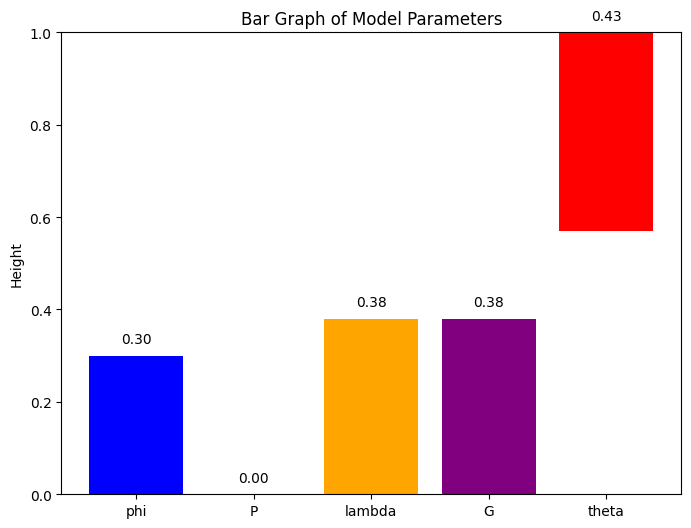

In [8]:
phi = param_c1['phi']
lamb = param_c1['lamb']
theta = param_c1['theta']
h = df1.loc[duration-1,'h']  # Example current level of P compartment
l = df1.loc[duration-1,'l']  # Example current level of G compartment

# Heights for bars
heights = [phi, 1 - h, lamb, 1 - l, 1 - (1 - theta)]  # Theta is now (1 - (1 - theta)) = theta

# Positions for bars
positions = np.arange(len(heights))
labels = ['phi', 'P', 'lambda', 'G', 'theta']

# Create bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, color=['blue', 'green', 'orange', 'purple', 'red'])

# Adjust theta bar to start from the top
bars[-1].set_y(1 - theta)

# Annotate bars with their heights
for i, (bar, height) in enumerate(zip(bars, heights)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.02, f'{height:.2f}',
             ha='center', va='bottom')

# Customize plot
plt.xticks(positions, labels)
plt.ylim(0, 1)  # Ensure the top of the graph is at 1 with some padding
plt.ylabel('Height')
plt.title('Bar Graph of Model Parameters')

plt.show()

779 total seconds of test
Pmec failure at t= 724 s, @ 350 W
Ptank failure at t= 770 s, @ 350 W


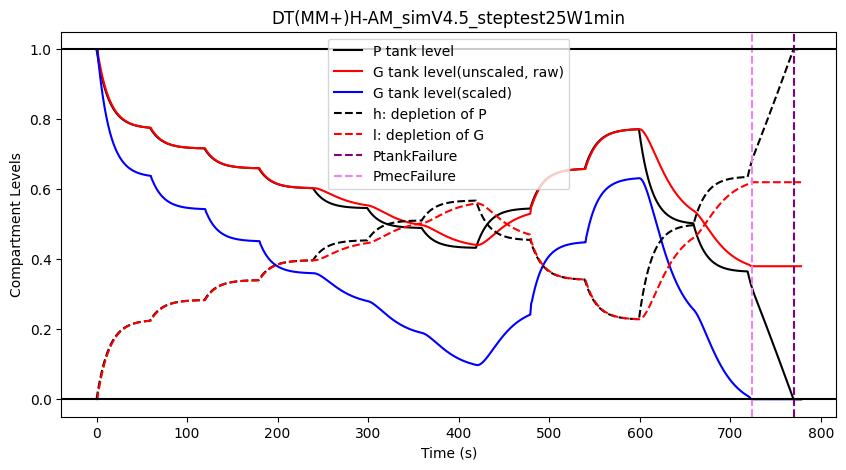

pmec W 247.3 fr pwrfrac, for constPwr sims only (ignore otherwise)
Pphys W 1075.2 fr pwrfrac, for constPwr sims only (ignore otherwise)
W from O2@end 308.2 W. i think correct
@end Pmax theo.: 0.0 W
VO2max of athlete: 64.1 ml/kg/min, at weight in kg of 64kg?? (need calc)
Max effective Pmec from aerobic 308.2 W (potential/limit)
WRONG FIX Crit Power % of VO2max (aerobic component only): 83.1 % see note below
from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max)
@end h, l, theta
1.0 0.62 0.43
Pmec@fail: 350 W


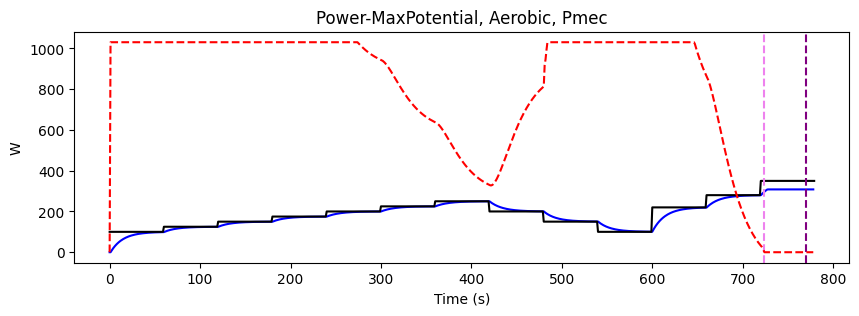

In [65]:
#V4: redoing dl/dt and dV_G/dt tank calcs. works better. 2/4 early morn lol
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
param_c1 = { # for Cyclist 1
    'eta': 0.23,  # Efficiency factor = Pmec@LT1/(%VO2max@LT1 * VO2max * C1)
    'MO': 1.34,   # Max oxidative energy flux (kJ/s)
    'MP': 4.48,   # Max mechanical power (kJ/s) = Pmec(max) / eta
    'MG': 9.15,   # Max glycolytic flux (kJ/s). MG of 285J/kg(muscle mass involved in task)
    'MR': 3.66,   # Max lactate recovery rate (kJ/s) = MG/2.5
    'AP': 27.79,  # Phosphagen store (kJ)
    'AG': 320.3,  # Glycolytic store (kJ)
    'AT': 11.27,  # Capillary glycolytic store (kJ) = [La]muscle@LT1 / theta * massMuscle * C2 (i think all over)
    'phi': 0.30,  # Height of O relative to P
    'theta': 0.43,  # Depth of G relative to P
    'lamb': 0.38  # Height of G relative to P
}
MG = param_c1['MG']
AG = param_c1['AG']
AP = param_c1['AP']
AT = param_c1['AT']
phi = param_c1['phi']
theta = param_c1['theta']
lamb = param_c1['lamb']
P_height = 1
#duration = 270  # 1 minut3
numbers = [100, 125,150,175,200,225,250,275,300,325,350, 375]
#numbers = [100,290,300,310,320,330,330]
#numbers = [175,200,225,250,275,300,325,350, 375]
numbers = [100, 125,150,175,200,225,250,200,150,100,220,280,350]
repeated_numbers = np.repeat(numbers, 60)
repeated_list = repeated_numbers.tolist()
duration = len(repeated_list)-1
print(duration,'total seconds of test')
max_pwr_frac_used = .24 #change this, just for const power demo
h_init = 0 # 0 is P = full i think. 1 = P empty
l_init = 0 #param_c1['theta'] # or 0?? # 0 is G=full, 1-lamb is G empty? very not sure on this one
C1=20.9 # J/ml energy/ml of oxygen, Fixed for now
C2=100 #J/mmol joules/accum lac in muscle
C3= 43.3 #J/mmol joules/PC stores in working muscles assuming all can be fully depleted (not true tech)
dl_dt_init = 0 #given in suppP1
df1 = pd.DataFrame(np.zeros((duration, 11)), columns=['h', 'l', 'Pmec', 'Pphys', 'P', 'G','Po2','Pmaxtheo','Failure',"G %(rel.)",'Lreal'])
df1.loc[0, 'h'] = h_init
df1.loc[0, 'l'] = l_init
df1.loc[0, 'Pmec'] = max_pwr_frac_used*param_c1['eta'] * param_c1['MP'] * 1000
df1.loc[0, 'Pphys'] = max_pwr_frac_used*param_c1['MP'] * 1000
df1.loc[0, 'P'] = 1  #P init full
df1.loc[0, 'G'] = 1  #G init empty
df1.loc[0,'G %(rel.)'] = 1
df1.loc[0,'Lreal'] = l_init #full capillary.
dt=1 #second
variable_pwr = True
global t_fail, t_fail_maxpwr
t_fail = 0
t_fail_maxpwr = 0
for i in range(1, duration):
    h_prev = df1.loc[i-1, 'h']
    l_prev = df1.loc[i-1, 'l']
    Pmec = repeated_list[i] / 1000 #conv raw W power profile to kJ/sec
    Pphys = Pmec / param_c1['eta']
    VO2 = min(param_c1['MO'] * (h_prev / (1 - param_c1['phi'])), param_c1['MO']) #from suppP2. power from O2 alone. # AKA: D_(O->P)
    #print('VO2 kJ/s',VO2)
    df1.loc[i,'Po2']=VO2 * 1000 * param_c1['eta']
    Pmax_theo_t = param_c1['MP']
    if l_prev > param_c1['theta']: #from indicator fn suppP1
      Pmax_theo_t = Pmax_theo_t * ((1 - param_c1['lamb'] - l_prev)/(1-param_c1['lamb']-param_c1['theta']))
    elif l_prev <= param_c1['theta']:
      Pmax_theo_t = Pmax_theo_t * ((1 - param_c1['lamb'] - param_c1['theta'])/(1-param_c1['lamb']-param_c1['theta']))
    df1.loc[i,'Pmaxtheo'] = Pmax_theo_t * 1000 * param_c1['eta']

    if Pmec*1000 < 190: #TODO: implem closed formula from params
      anaerob_flux = AT
      #print("AT")
    elif Pmec*1000 >= 190 and Pmec < 247: #TODO: implem closed formula from params
      anaerob_flux = AG
      #print("AG")
    else:
      anaerob_flux = AG
    dl_dt = (MG/anaerob_flux) * ((h_prev - l_prev)/(1 - lamb)) #supp p1,2: eqns 2,22
    #print('dl_dt',dl_dt)
    dh_dt = (Pphys - VO2 + dl_dt) / AP #my deriv see paper diag. dV_G = - dl/dt
    #print('dh_dt',dh_dt)

    # if (h_prev + (dh_dt * dt)) > P_height or (h_prev + (dh_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewH',h_prev + (dh_dt * dt)) # means attempted to do a dh that is impossibly big :(
    # if (l_prev + (dl_dt * dt)) > P_height - param_c1['lamb'] or (l_prev + (dl_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewL',l_prev + (dl_dt * dt)) # means attempted to do a dl that is impossibly big :(
    df1.loc[i, 'h'] = max(0, min(P_height, h_prev + (dh_dt * dt)))  # [0 to 1]
    df1.loc[i, 'l'] = max(0, min(P_height-param_c1['lamb'], l_prev + (dl_dt * dt)))  # [theta(or zero?) to 1-lamb]
    df1.loc[i, 'Pphys'] = Pphys
    df1.loc[i, 'P'] = 1-df1.loc[i, 'h']
    df1.loc[i, 'G'] = 1-df1.loc[i, 'l']
    df1.loc[i, 'G %(rel.)'] = (df1.loc[i, 'G'] - param_c1['lamb']) / (1-param_c1['lamb'])
    if i > 1:
      if 1-df1.loc[i, 'h'] == 0: #failure to complete exercise when P = 0 = empty
        if t_fail == 0:
          t_fail = i
          print("Ptank failure at t=",i,'s, @',repeated_list[i],'W')
      #break # can add anim here later
    #print(Pmax_theo_t, i)
    if i > 1:
      if Pmax_theo_t <= 0.001:
        if t_fail_maxpwr == 0:
          t_fail_maxpwr = i
          print('Pmec failure at t=',t_fail_maxpwr,'s, @',repeated_list[i],'W')
if t_fail == 0:
  t_fail = duration-1
  print("Ptank failure not reached, assigned at t=",t_fail,'s')


plt.figure(figsize=(10, 5))
plt.plot( df1['P'], label='P tank level',color='black')
plt.plot( df1['G'], label='G tank level(unscaled, raw)', color='red')
plt.plot( df1['G %(rel.)'], label='G tank level(scaled)', color='blue')
plt.plot( df1['h'], label='h: depletion of P', color='black',linestyle='--')
plt.plot( df1['l'], label='l: depletion of G', color='red',linestyle='--')
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
plt.axhline(1, linestyle='-', color='black')
plt.axhline(0, linestyle='-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Compartment Levels')
plt.legend()
plt.title('DT(MM+)H-AM_simV4.5_steptest25W1min')
plt.show()
print('pmec W',round(max_pwr_frac_used*param_c1['eta'] * param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
print('Pphys W',round(max_pwr_frac_used*param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
print("W from O2@end",round(df1.loc[duration-1,'Po2'],1),"W. i think correct")
plt.figure(figsize=(10, 3))
plt.plot(df1['Po2'],color='blue',label='aerobic power contrib')
plt.plot(repeated_list, color='black',label="output power")
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
print('@end Pmax theo.:',df1.loc[duration-1,'Pmaxtheo'],'W')
plt.plot(df1['Pmaxtheo'],color='red',linestyle='--', label="potential max power")
plt.xlabel('Time (s)')
plt.ylabel('W')
plt.title('Power-MaxPotential, Aerobic, Pmec')
print("VO2max of athlete:",round((param_c1['MO']*1000)/C1,1), "ml/kg/min, at weight in kg of 64kg?? (need calc)")
print("Max effective Pmec from aerobic", round(((param_c1['MO']*1000*param_c1['eta']))  ,1),"W (potential/limit)") # i think this is correct to show max mech watts from aerobic pwr
#(1-param_c1['phi']) + ((param_c1['MO'])/(param_c1['MP'])) * (1-param_c1['theta']-param_c1['lamb'])
#print("Critical PowerWRONG:", param_c1['eta']*((param_c1['MO']*(1-param_c1['lamb']))/((1-param_c1['phi']) + ((param_c1['MO'])/((param_c1['MP']) * (1-param_c1['theta']-param_c1['lamb']))))))
print("WRONG FIX Crit Power % of VO2max (aerobic component only):",round(100*param_c1['MO']*(1-param_c1['lamb']),1),"% see note below")
print("from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max)")
print('@end h, l, theta')
print(round(df1.loc[duration-1,'h'],2),round(df1.loc[duration-1,'l'],2),param_c1['theta'])
print('Pmec@fail:',repeated_list[t_fail],'W')

In [ ]:
#V5: trying to get actual L height dynamics with capillary A_T
#V4: redoing dl/dt and dV_G/dt tank calcs. works better. 2/4 early morn lol
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as patches
from matplotlib.animation import PillowWriter
from google.colab import files
param_c1 = { # for Cyclist 1
    'eta': 0.2551,  # Efficiency factor = Pmec@LT1/(%VO2max@LT1 * VO2max * C1)
    'MO': 1.34,   # Max oxidative energy flux (kJ/s)
    'MP': 4.48,   # Max mechanical power (kJ/s) = Pmec(max) / eta
    'MG': 9.15,   # Max glycolytic flux (kJ/s). MG of 285J/kg(muscle mass involved in task)
    'MR': 3.66,   # Max lactate recovery rate (kJ/s) = MG/2.5
    'AP': 27.79,  # Phosphagen store (kJ)
    'AG': 320.3,  # Glycolytic store (kJ)
    'AT': 11.27,  # Capillary glycolytic store (kJ) = [La]muscle@LT1 / theta * massMuscle * C2 (i think all over)
    'phi': 0.30,  # Height of O relative to P
    'theta': 0.43,  # Depth of G relative to P
    'lamb': 0.38  # Height of G relative to P
}
MG = param_c1['MG']
eta = param_c1['eta']
MP = param_c1['MP']
MR = param_c1['MR']
MO = param_c1['MO']
AG = param_c1['AG']
AP = param_c1['AP']
AT = param_c1['AT']
phi = param_c1['phi']
theta = param_c1['theta']
lamb = param_c1['lamb']
P_height = 1
#duration = 270  # 1 minut3
#numbers = [100, 125,150,175,200,225,250,275,300,325,350, 375]
#numbers = [100,290,300,310,320,330,330]
#numbers = [175,200,225,250,275,300,325,350, 375]
#numbers = [100, 125,150,175,200,225,250,200,150,100,50,220,280,350]
#numbers = [100,200,300,315]
#numbers = [400,400,400]
#numbers = [150,200,250,260,270,280,290,300,310,320] #cyclist 1 investigating props around CP 280W
numbers = [295,295,295,295,295,295,295]
reps=60
repeated_numbers = np.repeat(numbers, reps)
repeated_list = repeated_numbers.tolist()
duration = len(repeated_list)-1
print(duration,'total seconds of test')
h_init = 0 # 0 is P = full i think. 1 = P empty
l_init = 0 #param_c1['theta'] # or 0?? # 0 is G=full, 1-lamb is G empty? very not sure on this one
C1=20.9 # J/ml energy/ml of oxygen, Fixed for now
C2=100 #J/mmol joules/accum lac in muscle
C3= 43.3 #J/mmol joules/PC stores in working muscles assuming all can be fully depleted (not true tech)
dl_dt_init = 0 #given in suppP1
df1 = pd.DataFrame(np.zeros((duration, 11)), columns=['h', 'l', 'Pmec', 'Pphys', 'P', 'G','Po2','Pmaxtheo','Failure',"G %(rel.)",'Lreal'])
df1.loc[0, 'h'] = h_init
df1.loc[0, 'l'] = l_init
df1.loc[0, 'P'] = 1  #P init full
df1.loc[0, 'G'] = 1  #G init empty
df1.loc[0,'G %(rel.)'] = 1
df1.loc[0,'Lreal'] = l_init #full capillary.
dt=1 #second
variable_pwr = True
global t_fail, t_fail_maxpwr
t_fail = 0
t_fail_maxpwr = 0

pheight = 5
pwidth = 10
output_file = 'simV5gif1.gif'# didnt workr"C:\Users\John DeForest\Downloads\sine_wave_animation.gif"
pwriter =  PillowWriter(fps=6)
fig1, ax1 = plt.subplots() #lowerleft coord of rect
fig1.set_size_inches(pwidth, pheight)
ax1.set_xlim(0, pwidth)
ax1.set_ylim(0, 1)
pwriter.setup(fig1, output_file)


for i in range(1, duration):
    h_prev = df1.loc[i-1, 'h']
    l_prev = df1.loc[i-1, 'l']
    Pmec = repeated_list[i] / 1000 #conv raw W power profile to kJ/sec
    Pphys = Pmec / param_c1['eta']
    VO2 = min(MO * (h_prev / (1 - phi)), MO) #from suppP2. power from O2 alone. # AKA: D_(O->P)
    #print('VO2 kJ/s',VO2)
    df1.loc[i,'Po2']=VO2 * 1000 * param_c1['eta']
    Pmax_theo_t = MP
    if l_prev > theta: #from indicator fn suppP1
      Pmax_theo_t = Pmax_theo_t * ((1 - lamb - l_prev)/(1-lamb-theta))
    elif l_prev <= theta:
      Pmax_theo_t = Pmax_theo_t * ((1 - lamb - theta)/(1-lamb-theta))
    df1.loc[i,'Pmaxtheo'] = Pmax_theo_t * 1000 * param_c1['eta']


    #TODO: add checks to make sure fluxes dont exceed MG/MR/MO etc
    unsc_dl_dt = ((h_prev - l_prev)/(1 - lamb)) #"fluid volume" change (took dl * baseArea(arb))
    if unsc_dl_dt < 0: #negative dl, G heading UP = RECOVERY FLUX GOVERNED BY MR
      if l_prev <= theta: #fluid lvl alr up in capillary, dl gov. by AT
        dl_dt = (MR/AT) * ((h_prev - l_prev)/(1 - lamb)) #supp p1,2: eqns 2
      elif l_prev > theta: #fluid lvl in Gtank, but could move up to capillary
        hG = l_prev - theta #get height of GtankTop above l_prev
        dl1 = hG
        if abs(MR*unsc_dl_dt) > hG * AG: #going to go up capillary
          spillover = abs(MR*unsc_dl_dt) - (hG * AG)
          dl2 = spillover / AT
          dl_dt = - (dl1 + dl2) #dl1 always pos here, dl2 also always pos^, ^^. so dl_dt needs to b neg.
        elif abs(MR*unsc_dl_dt) <= hG * AG: #NOT going to go up cap
          dl_dt = MR*unsc_dl_dt / AG #unscdl should b neg, so dldt should b neg.
      else:
        print('unsc_dl_dt neg, err w fluid lvl rel2 capillary-UP')

    elif unsc_dl_dt >= 0: #positive dl, G heading DOWN, gov by MG
      if l_prev >= theta: #fluid lvl alr down in Gtank, dl gov. by AG
        dl_dt = (MG/AG) * ((h_prev - l_prev)/(1 - lamb)) #supp p1,2: eqns 22
      elif l_prev < theta: #fluid lvl in capillary, but could move down to Gtank
        hT = theta - l_prev #get height of fluid in capillary down to top of Gtank
        dl1 = hT
        if abs(MG*unsc_dl_dt) > hT * AT: #going to go down to Gtank
          spillover = abs(MG*unsc_dl_dt) - (hT * AT)
          dl2 = spillover / AG
          dl_dt =  (dl1 + dl2) #dl1 alw pos, dl2 pos, so dldt pos. G goes down.
        elif abs(MG*unsc_dl_dt) <= hT * AT: #NOT going to go down to Gtank
          dl_dt = MG*unsc_dl_dt / AT #unscdl should b pos, so dldt should b
      else:
        print('unsc_dl_dt pos, err w fluid lvl rel2 capillary-DOWN')
    else:
      print('unsc_dl_dt err ugh mcfuckus')

    #doesnt work check units ig????? FIX TODO HELP
    #wrong bc of signage errors: #dh_dt = -(Pphys - VO2 - abs(unsc_dl_dt)) / AP #see paper deriv backside. needs unscl for volume apples to apples.
    #TODO FIX dl_dt SCALING - figure out flux equiv???: i think wrong v: bc dldt is not a "volume" (kJ/sec) like the other quantities
    dh_dt = (Pphys - VO2 - dl_dt) / AP #my deriv see paper diag. dV_G = - dl/dt?
    #print('dh_dt',dh_dt)
    # if (h_prev + (dh_dt * dt)) > P_height or (h_prev + (dh_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewH',h_prev + (dh_dt * dt)) # means attempted to do a dh that is impossibly big :(
    # if (l_prev + (dl_dt * dt)) > P_height - param_c1['lamb'] or (l_prev + (dl_dt * dt)) <0:
    #   #break #ignore print for now
    #   print('attNewL',l_prev + (dl_dt * dt)) # means attempted to do a dl that is impossibly big :(
    df1.loc[i, 'h'] = max(0, min(P_height, h_prev + (dh_dt * dt)))  # [0 to 1]
    df1.loc[i, 'l'] = max(0, min(P_height-param_c1['lamb'], l_prev + (dl_dt * dt)))  # [theta(or zero?) to 1-lamb]
    df1.loc[i, 'Pphys'] = Pphys
    df1.loc[i, 'P'] = 1-df1.loc[i, 'h']
    df1.loc[i, 'G'] = 1-df1.loc[i, 'l']
    df1.loc[i, 'G %(rel.)'] = (df1.loc[i, 'G'] - param_c1['lamb']) / (1-param_c1['lamb'])

    h_curr = df1.loc[i, 'h']
    l_curr = df1.loc[i, 'l']
    Pphys_curr = df1.loc[i, 'Pphys']
    Pmec_curr = repeated_list[i] #in Watts output power
    Po2_curr = df1.loc[i, 'Po2']
    P_curr = df1.loc[i, 'P']
    G_curr = df1.loc[i, 'G']
    G_rel_curr = df1.loc[i, 'G %(rel.)']

    if i > 1:
      if 1-df1.loc[i, 'h'] == 0: #failure to complete exercise when P = 0 = empty
        if t_fail == 0:
          t_fail = i
          print("Ptank failure at t=",i,'s, @',repeated_list[i],'W')
    if i > 1:
      if Pmax_theo_t <= 0.001:
        if t_fail_maxpwr == 0:
          t_fail_maxpwr = i
          print('Pmec failure at t=',t_fail_maxpwr,'s, @',repeated_list[i],'W')
    frames = duration
    pheight = 5
    pwidth = 10
    owid = (1/5) * pwidth
    gap1 = 1/10
    gap2=1/10
    remaining = pwidth - ((gap1+gap2+owid/5)*pwidth)
    remfrac = remaining / pwidth
    Pwid = (AP / (AP + AG)) * remfrac
    Gwid = (AG / (AP + AG)) * remfrac
    ohi = 1-phi

    G_kJ_left = 0
    if l_curr > theta:
      G_kJ_left = AG * G_rel_curr
    elif l_curr <= theta:
      G_kJ_left = AG*((1-theta-lamb)/(1-lamb)) + AT * ((theta-l_curr)/(1-lamb))


    ax1.clear()
    ax1.set_xlim(0, pwidth)
    ax1.set_ylim(0, 1)

    obox = patches.Rectangle((0, phi), owid, pheight, color='lightblue', alpha=0.3)
    ax1.add_patch(obox)

    text1 = 'current Pmec W: ' + str(Pmec*1000) + ', t=' + str(i) + 's, (Pphys W:' + str(round(Pphys*1000,1)) + ')'
    ax1.text(.2, 0.05, text1, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    GkJ_text = ', G kJ left: ' + str(round(G_kJ_left,2))
    text2 = 'G: ' + str(round( df1.loc[i, 'G'],2)) + ', G%:'+ str(round(df1.loc[i, 'G %(rel.)'] * 100,2)) + GkJ_text
    ax1.text(.41, 0.285, text2, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    text3 = 'P: ' + str(round(df1.loc[i, 'P'],2)) + ', h: ' + str(round(df1.loc[i, 'h'],2)) + ', l: ' + str(round(df1.loc[i, 'l'],2))
    ax1.text(.01, 0.25, text3, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    text4 = 'simV6 - Pmec W profile: ' + str(numbers) + 'ea for' + str(reps) + 's'
    ax1.text(.25, 1.12, text4, transform=ax1.transAxes, fontsize=12, verticalalignment='top')
    pbox = patches.Rectangle((owid+(gap1*pwidth), 0), Pwid*pwidth, df1.loc[i, 'P'], color='grey', alpha=0.3)
    ax1.add_patch(pbox)
    gbox = patches.Rectangle((owid+(gap1*pwidth)+Pwid*pwidth+(gap2*pwidth), lamb),
                             Gwid*pwidth,df1.loc[i, 'G']-lamb , color='orange', alpha=0.3)
    ax1.add_patch(gbox)
    chimNotWidth = (Gwid*pwidth) - ((AT/AP)*(Pwid*pwidth))
    gchimNot = patches.Rectangle((owid+(gap1*pwidth)+Pwid*pwidth+(gap2*pwidth), 1-theta),
                                 chimNotWidth ,theta , color='white', alpha=0.85)
    ax1.add_patch(gchimNot)

    pwriter.grab_frame()

pwriter.finish()
plt.close(fig1)
files.download('simV5gif1.gif')
#fig1.savefig('anim1.gif', writer='pillow')
if t_fail == 0:
  t_fail = duration-1
  print("Ptank failure not reached, assigned at t=",t_fail,'s')

plt.figure(figsize=(10, 5))
plt.plot( df1['P'], label='P tank level',color='black')
plt.plot( df1['G'], label='G tank level(unscaled, raw)', color='red')
plt.plot( df1['G %(rel.)'], label='G tank level(scaled)', color='blue')
plt.plot( df1['h'], label='h: depletion of P', color='black',linestyle='--')
plt.plot( df1['l'], label='l: depletion of G', color='red',linestyle='--')
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
plt.axhline(1, linestyle='-', color='black')
plt.axhline(0, linestyle='-', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Compartment Levels')
plt.legend()
plt.title('DT(MM+)H-AM_simV5.1_steptest25W1min')
plt.show()
#print('pmec W',round(max_pwr_frac_used*param_c1['eta'] * param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
#print('Pphys W',round(max_pwr_frac_used*param_c1['MP'] * 1000,1), 'fr pwrfrac, for constPwr sims only (ignore otherwise)')
print("W from O2@end",round(df1.loc[duration-1,'Po2'],1),"W. i think correct")
plt.figure(figsize=(10, 3))
plt.plot(df1['Po2'],color='blue',label='aerobic power contrib')
plt.plot(repeated_list, color='black',label="output power")
plt.axvline(t_fail, linestyle='--', color='purple', label='PtankFailure')
plt.axvline(t_fail_maxpwr, linestyle='--', color='violet', label='PmecFailure')
print('@end Pmax theo.:',df1.loc[duration-1,'Pmaxtheo'],'W')
plt.plot(df1['Pmaxtheo'],color='red',linestyle='--', label="potential max power")
plt.xlabel('Time (s)')
plt.ylabel('W')
plt.title('Power-MaxPotential, Aerobic, Pmec')
print("VO2max of athlete:",round((param_c1['MO']*1000)/C1,1), "ml/kg/min, at weight in kg of 64kg?? (need calc)")
print("TODO I THINK THIS IS WRONG - BOILLET SIM HAS REACHING 295w in supraCP test Max effective Pmec from aerobic", round(((param_c1['MO']*1000*param_c1['eta']))  ,1),"W (potential/limit)") # i think this is correct to show max mech watts from aerobic pwr
print("WRONG FIX Crit Power % of VO2max (aerobic component only):",round(100*param_c1['MO']*(1-param_c1['lamb']),1),"% see note below")
print("from sims: LT1@190w(18.5%Max) / LT2@247w(24.0%Max) TODO FIX FROM PAPER SHOULD BE 280W CP")
print('@end h, l, theta | w/ eta: ',str(eta))
print(round(df1.loc[duration-1,'h'],2),round(df1.loc[duration-1,'l'],2),param_c1['theta'])
print('Pmec@tfail(P=0):',repeated_list[t_fail],'W','Pmec@tfailtheomax(G=0):',repeated_list[t_fail_maxpwr],'W')

419 total seconds of test


In [78]:
#useful values:
MP = param_c1['MP']
MO = param_c1['MO']
theta = param_c1['theta']
lamb = param_c1['lamb']
phi = .3 #or use .25 from dif paper
pct_vo2max_lt1 = theta / (1-phi)
num1 = 1-lamb
denom1 = (1-phi) + (MO/MP) * (1-theta-lamb) #TODO: NOT SURE PEMDAS IS HARD SEE p6 main
pct_vo2max_PC = num1/denom1
print('%VO2max @LT1 aka alpha: ',round(pct_vo2max_lt1*100,1),'%')
print('%VO2max @PC aka beta: ',round(pct_vo2max_PC*100,1),'%')
Pmec_lt1 = 190 #W, from my testing of my model... not from params...
vo2max_c1 = (param_c1['MO']*1000)/C1 #ml/kg/min i think correct? for cyclist 1
eta_1 = Pmec_lt1 / (pct_vo2max_lt1 *  vo2max_c1 * C1) #denom: frac * mlO2/kg/min * J/mlO2
print('eta1: ',round(eta_1,3)) #~.23 checks out?

#UPD: fixed? via jank re-est of ETA (below), still need to redo sims to confirm. TODO FIX NOTE as state in paper p8 ~195W is BELOW LT1 apparently for Cyclist 1
#units fixing
paper_pmec_lt1 = 200 #guessing here, where h = l = theta (still j in capillary region at const power)
athlete_weight = 64 # kg
weight = athlete_weight

eta_2 = paper_pmec_lt1 / (pct_vo2max_lt1 *  vo2max_c1 * C1 * weight * (1/60))
print('eta2:', round(eta_2,3))

Pmec_CP1 = eta_1 * C1 * pct_vo2max_PC * vo2max_c1 # eqn (3) on p2 of supp
print('Pmec_CP1(eta1+paper): ', round(Pmec_CP1,1),'W')
Pmec_CP2 = (eta_2 * MO*1000 * num1) * (1/denom1) # eqn (3) on p2 of supp, needed *1000 to get W, not kJ/sec
print('Pmec_CP2(eta2): ', round(Pmec_CP2,1),'W')

#to get 280W supposed CP for Cyclist1:
eta_needed = .2551 #tried a buncha vals until it hit 280 lol.
Pmec_CP3 = (eta_needed * MO*1000 * num1) * (1/denom1) # eqn (3) on p2 of supp, needed *1000 to get W, not kJ/sec
print('Pmec_CP3(eta_needed): ', round(Pmec_CP3,1),'W')
#ok. am going to use that then for eta, not .23.

%VO2max @LT1 aka alpha:  61.4 %
%VO2max @PC aka beta:  81.9 %
eta1:  0.231
eta2: 0.228
Pmec_CP1(eta1+paper):  253.4 W
Pmec_CP2(eta2):  250.0 W
Pmec_CP3(eta_needed):  280.0 W
